In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Download price data
ticker = "AAPL"
df = yf.download(ticker, start="2015-01-01", progress=False)

# Keep required columns
df = df[['Close']].copy()
df.dropna(inplace=True)

df.head()


Price,Close
Ticker,AAPL
Date,
2015-01-02,24.237551
2015-01-05,23.554747
2015-01-06,23.556959
2015-01-07,23.887276
2015-01-08,24.805080


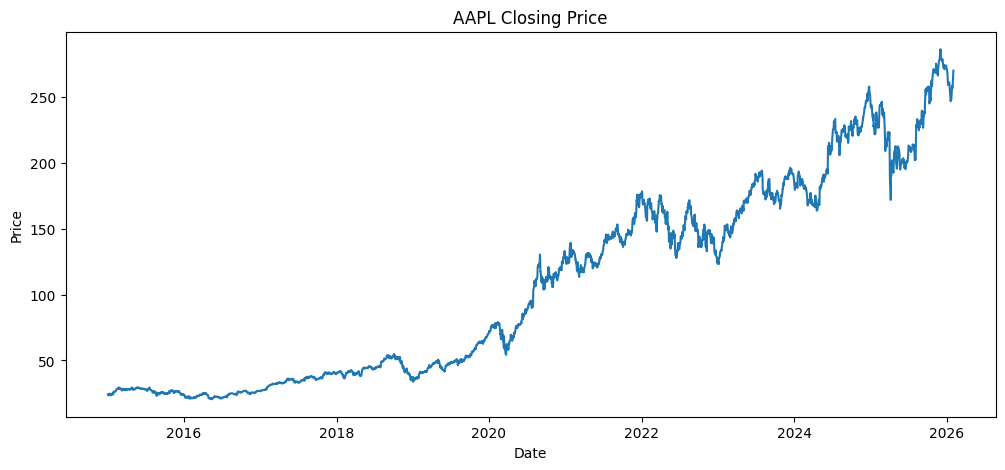

In [4]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'])
plt.title(f"{ticker} Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [5]:
def backtest_strategy(df, signal_col):
    data = df.copy()
    
    # Position uses yesterday's signal (no look-ahead bias)
    data['position'] = data[signal_col].shift(1).fillna(0)
    
    # Daily returns
    data['returns'] = data['Close'].pct_change()
    
    # Strategy returns
    data['strategy_returns'] = data['position'] * data['returns']
    
    # Equity curve
    data['equity'] = (1 + data['strategy_returns']).cumprod()
    
    # Trade count (entries only)
    trades = ((data['position'] == 1) & (data['position'].shift(1) == 0)).sum()
    
    total_return = data['equity'].iloc[-1] - 1
    
    return data, total_return, trades


In [6]:
roc_n = 10          # lookback window (days)
roc_threshold = 0.03  # 3% threshold


In [7]:
df['roc'] = df['Close'].pct_change(periods=roc_n)


In [8]:
df['signal'] = (df['roc'] > roc_threshold).astype(int)


In [9]:
results, total_return, num_trades = backtest_strategy(df, 'signal')

print(f"Total return: {total_return:.2%}")
print(f"Number of trades: {num_trades}")


Total return: 166.03%
Number of trades: 183


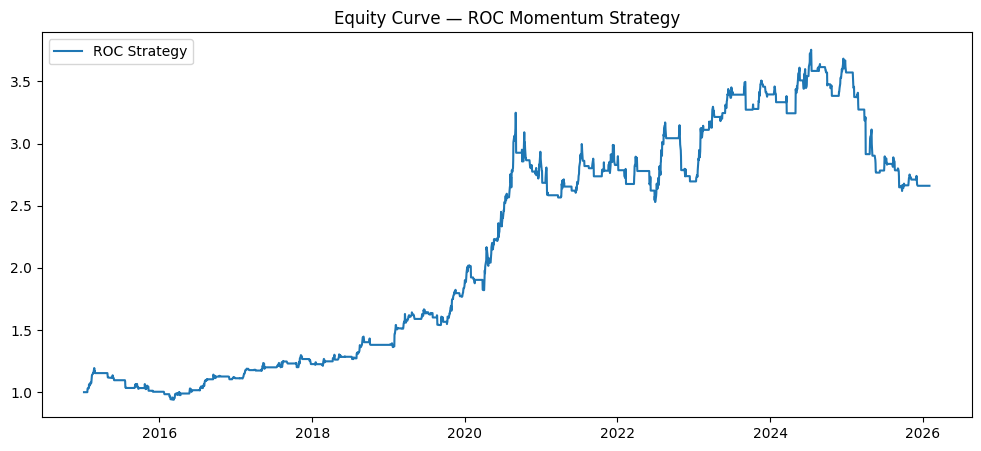

In [10]:
plt.figure(figsize=(12,5))
plt.plot(results.index, results['equity'], label='ROC Strategy')
plt.title("Equity Curve — ROC Momentum Strategy")
plt.legend()
plt.show()


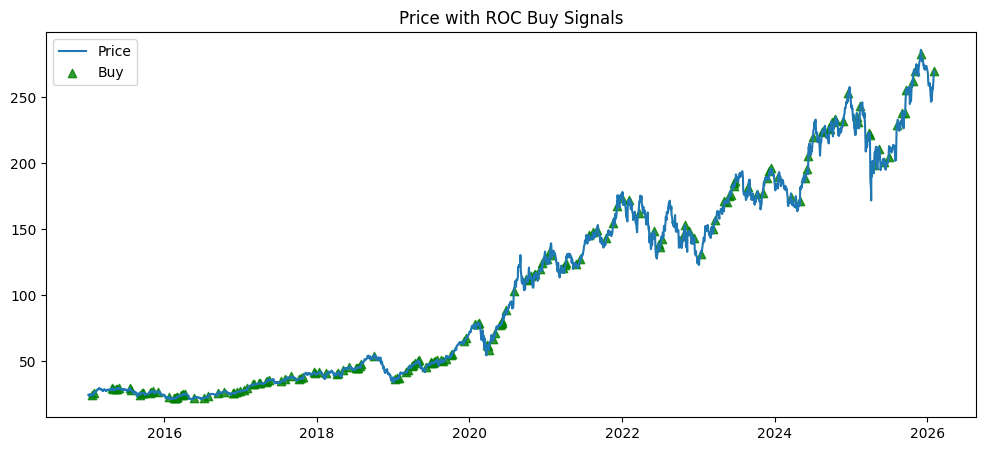

In [11]:
plt.figure(figsize=(12,5))
plt.plot(results.index, results['Close'], label='Price')

buy_signals = results[(results['signal'] == 1) & (results['signal'].shift(1) == 0)]
plt.scatter(buy_signals.index, buy_signals['Close'], 
            marker='^', color='green', label='Buy', alpha=0.8)

plt.title("Price with ROC Buy Signals")
plt.legend()
plt.show()
